### ORIE 6750 Homework 4 Question 3
Comparing four heuristics for best arm identification:
* Random sampling
* Knowledge gradient
* Thompson sampling
* Upper confidence bound

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad

Belief state $B_n$ of each arm $i$ is parameterized by the posterior mean $\mu_{i,n}$ and $h_{i,n}$, the number that arm $i$ has been pulled up to time $n$. The posterior variance is given by $\sigma_{i,n}^2=(h_{i,n}+1)^{-1}$.

In [2]:
# Random sampling

def value_random(H, K, n_iter, lamb=1):
    
    values = np.zeros(n_iter)
    
    for ind_iter in range(n_iter):
        
        B = np.zeros((K,2))
        theta = np.random.normal(0,1,K)
        
        for n in range(1, H+1):
            
            pull = np.random.randint(0, K)
            
            Y = np.random.normal(theta[pull], lamb)
            
            beta_pull = (B[pull,1]+1) / (B[pull,1]+2)
            B[pull,0] = B[pull,0]*beta_pull + (1-beta_pull)*Y
            B[pull,1] += 1
        
        
        values[ind_iter] = np.max([B[0,0], B[1,0]])

    return np.mean(values)

In [46]:
# Knowledge Gradient 

# First define function for computing Q-factor
def compute_Q(mu, h, best_mu):
    beta = (h+1)/(h+2)
    ystar = (best_mu - beta*mu)/(1-beta)
    
    integrand = lambda theta, mu, h, best_mu, beta, ystar: \
                    (norm.cdf(ystar-theta)*(best_mu-beta*mu-(1-beta)*(theta+1)) +\
                    beta*mu + (1-beta)*(theta+1)) *\
                    np.sqrt((h+1)/(2*np.pi)) * np.exp(-(theta-mu)**2*(h+1)/2)
    
    integral = quad(integrand, -np.inf, np.inf, args = (mu,h,best_mu,beta,ystar))[0]

    return integral


def value_KG(H, K, n_iter):
    
    best_mu_record = np.zeros(n_iter)
    
    for ind_iter in range(n_iter):
    
        B = np.zeros((K,2))
        theta = np.random.normal(0,1,K)

        best_mu=0

        for n in range(1,H+1):

            Q = np.zeros(K)
            for k in range(K):
                # compute Q-factor given by knowledge gradient
                if n > 1:    
                    if k == pull:
                        Q[k] = compute_Q(B[k,0], B[k,1], best_mu)
                    else:
                        Q[k] = Q_cache[k]
            
            Q_cache = Q
            
            pull = np.argmax(Q)

            Y = np.random.normal(theta[pull], 1)
            beta_pull = (B[pull,1]+1) / (B[pull,1]+2)
            B[pull,0] = B[pull,0]*beta_pull + (1-beta_pull)*Y
            B[pull,1] += 1

            best_mu = np.amax(B[:,0])

        best_mu_record[ind_iter] = best_mu

    
    return np.mean(best_mu_record)


In [4]:
# Thompson sampling

def value_Thompson(H, K, n_iter, lamb=1):
    
    values = np.zeros(n_iter)
    
    for ind_iter in range(n_iter):
        
        B = np.zeros((K,2))
        theta = np.random.normal(0,1,K)
        
        for n in range(1,H+1):
            
            theta_sampled = np.zeros(K)
            for k in range(K):
                theta_sampled[k] = np.random.normal(B[k,0], (B[k,1]+1)**(-1/2))

            pull = np.argmax(theta_sampled)

            if n < H:
                Y = np.random.normal(theta[pull], lamb)
                beta_pull = (B[pull,1]+1) / (B[pull,1]+2)
                B[pull,0] = B[pull,0]*beta_pull + (1-beta_pull)*Y
                B[pull,1] += 1
        
        values[ind_iter] = np.max([B[0,0], B[1,0]])
        
    return np.mean(values)

In [6]:
# Upper confidence bound (UCB)

def value_UCB(H, K, n_iter, lamb=1, beta=1.96):
    
    values = np.zeros(n_iter)
    
    for ind_iter in range(n_iter):
        
        # belief states: (posterior mean, number pulled)
        B = np.zeros((K,2))
        theta = np.random.normal(0,1,K)
        
        for n in range(1,H):
            
            UCB = B[:,0] + beta*B[:,1]
            
            if n==1:
                pull = np.random.randint(0,K)
            else:
                pull = np.argmax(UCB)

            Y = np.random.normal(theta[pull], lamb)
            
            beta_pull = (B[pull,1]+1) / (B[pull,1]+2)
            B[pull,0] = B[pull,0]*beta_pull + (1-beta_pull)*Y
            B[pull,1] += 1
                
        values[ind_iter] = np.max([B[0,0], B[1,0]])
    
    return np.mean(values)

In [9]:
random_values = np.zeros(30)

for H in range(30):
    random_values[H]=value_random(H+1, 10, 10000)


In [47]:
pull=None
KG_values = np.zeros(30)

for H in range(30):
    print(H)
    KG_values[H] = value_KG(H+1, 10, 1000)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [10]:
Thompson_values = np.zeros(30)

for H in range(30):
    print(H)
    Thompson_values[H]=value_Thompson(H+1, 10, 10000)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [7]:
UCB_values = np.zeros(30)

for H in range(30):
    print(H)
    UCB_values[H]=value_UCB(H+1, 10, 1000)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


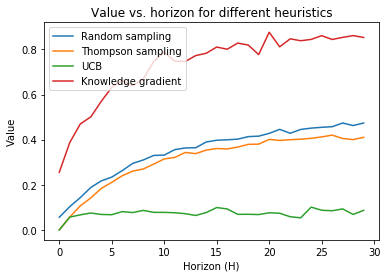

In [51]:
plt.plot(random_values, label='Random sampling')
plt.plot(Thompson_values, label='Thompson sampling')
plt.plot(UCB_values, label='UCB')
plt.plot(KG_values, label='Knowledge gradient')

plt.xlabel('Horizon (H)')
plt.ylabel('Value')
plt.title('Value vs. horizon for different heuristics')
plt.legend(loc='best')

In [11]:
sev1 = np.array([0.17, 0.52, 0.31, 0.13, 0.13])
pop_mj = np.array([0, 0.6534, 0.3222, 0.021, 0.0034])
pop_fall = np.array([0, 0.8581, 0.1317, 0.0088, 0.0014])

In [12]:
np.dot(sev1, pop_mj)

0.442822

In [13]:
np.dot(sev1, pop_fall)

0.488365

In [14]:
sev2 = np.array([0.816, 0.472, 0.659, 0.806, 0.806])
sev3 = np.array([0.011, 0.006, 0.022, 0.047, 0.047])
sev4 = np.array([0.003, 0.002, 0.009, 0.017, 0.017])

In [17]:
np.dot(sev2, pop_mj), np.dot(sev2, pop_fall)

(0.5404009999999999, 0.5000346999999999)

In [74]:
sev1_opt = np.array([0.05, 0.04, 0.04, 0.04, 0.03])
sev1_pess = np.array([0.15, 0.1, 0.1, 0.1, 0.05])

np.dot(sev1_opt, pop_fall), np.dot(sev1_pess, pop_fall)

(0.039986, 0.09993)

In [76]:
sev4 = np.array([0.01, 0.13, 0.17, 0.23, 0.4])
np.dot(sev4, pop_fall), np.dot(sev4, pop_fall)

(0.136526, 0.136526)

In [18]:
infection = np.array([0.018, 0.022, 0.029, 0.042, 0.042])
infection * sev1

array([0.00306, 0.01144, 0.00899, 0.00546, 0.00546])

In [21]:
s11, s12 = np.dot(infection*sev1, pop_mj),  np.dot(infection*sev1, pop_fall)
s21, s22 = np.dot(infection*sev2, pop_mj),  np.dot(infection*sev2, pop_fall)
s31, s32 = np.dot(infection*sev3, pop_mj),  np.dot(infection*sev3, pop_fall)
s41, s42 = np.dot(infection*sev4, pop_mj),  np.dot(infection*sev4, pop_fall)

In [36]:
s11/(s11+s21+s31+s41)

0.42454545454545456

In [33]:
s42 / (s12 + s22 + s32 + s42)

0.0034339377062081915